In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikiart/classes.csv
/kaggle/input/wikiart/wclasses.csv
/kaggle/input/wikiart/Pop_Art/nicholas-krushenick_untitled-1963.jpg
/kaggle/input/wikiart/Pop_Art/walter-battiss_horse-and-butterfly.jpg
/kaggle/input/wikiart/Pop_Art/hiro-yamagata_normandies-1979.jpg
/kaggle/input/wikiart/Pop_Art/roy-lichtenstein_head-red-and-yellow-1962(1).jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_coca-cola.jpg
/kaggle/input/wikiart/Pop_Art/leroy-neiman_john-elway-1999.jpg
/kaggle/input/wikiart/Pop_Art/hiro-yamagata_not-detected-272397.jpg
/kaggle/input/wikiart/Pop_Art/marko-pogacnik_bottle-3.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_absolut-vodka(1).jpg
/kaggle/input/wikiart/Pop_Art/martial-raysse_verte-1963.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_frog.jpg
/kaggle/input/wikiart/Pop_Art/r.-b.-kitaj_if-not-not.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_marilyn-1.jpg
/kaggle/input/wikiart/Pop_Art/andy-warhol_marella-agnelli-1973.jpg
/kaggle/input/wikiart/Pop_Art/r.-b.-kitaj_la-hispani

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("steubk/wikiart")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/wikiart


In [3]:
import os

dataset_path = "/kaggle/input/wikiart"

# List files and folders in the dataset directory
print("Contents of dataset folder:", os.listdir(dataset_path))

Contents of dataset folder: ['Pop_Art', 'Minimalism', 'Color_Field_Painting', 'Mannerism_Late_Renaissance', 'Symbolism', 'Impressionism', 'Contemporary_Realism', 'High_Renaissance', 'Fauvism', 'Rococo', 'Early_Renaissance', 'Naive_Art_Primitivism', 'Pointillism', 'classes.csv', 'Cubism', 'Synthetic_Cubism', 'Action_painting', 'Abstract_Expressionism', 'New_Realism', 'wclasses.csv', 'Baroque', 'Analytical_Cubism', 'Expressionism', 'Romanticism', 'Northern_Renaissance', 'Ukiyo_e', 'Post_Impressionism', 'Art_Nouveau_Modern', 'Realism']


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
import numpy as np
import random
import cv2

# Define image transformations 
to_tensor = transforms.ToTensor()
resize = transforms.Resize((128, 128))



In [5]:
# Realistic damage function (blur, scribble, and patch)
def apply_realistic_damage(img):
    img_np = np.array(img)

    # Blur
    if random.random() < 0.3:
        k = random.choice([3, 5])
        img_np = cv2.GaussianBlur(img_np, (k, k), 0)

    # Scribble
    if random.random() < 0.3:
        for _ in range(random.randint(1, 3)):
            x1, y1 = random.randint(0, img_np.shape[1]), random.randint(0, img_np.shape[0])
            x2, y2 = random.randint(0, img_np.shape[1]), random.randint(0, img_np.shape[0])
            cv2.line(img_np, (x1, y1), (x2, y2), (0, 0, 0), thickness=random.randint(1, 3))

    # Gray patch
    if random.random() < 0.5:
        patch_size = random.randint(20, 50)
        x = random.randint(0, img_np.shape[1] - patch_size)
        y = random.randint(0, img_np.shape[0] - patch_size)
        img_np[y:y+patch_size, x:x+patch_size] = 200

    return Image.fromarray(img_np)




In [6]:
# Custom dataset
class DamagedArtDataset(Dataset):
    def __init__(self, root_dir, subset_size=500):
        self.root_dir = root_dir
        self.image_paths = []

        for subdir in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subdir)
            if os.path.isdir(sub_path):
                self.image_paths.extend([os.path.join(sub_path, img) for img in os.listdir(sub_path)[:subset_size]])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        original = Image.open(img_path).convert("RGB")
        original = resize(original)
        damaged = apply_realistic_damage(original.copy())
        return to_tensor(damaged), to_tensor(original)

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, 2, 1, 1), nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Load data
path = "/kaggle/input/wikiart"
dataset = DamagedArtDataset(path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Train setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Epoch [1/10], Loss: 0.0115
Epoch [2/10], Loss: 0.0069
Epoch [3/10], Loss: 0.0061
Epoch [4/10], Loss: 0.0055
Epoch [5/10], Loss: 0.0051
Epoch [6/10], Loss: 0.0047
Epoch [7/10], Loss: 0.0045
Epoch [8/10], Loss: 0.0043
Epoch [9/10], Loss: 0.0042
Epoch [10/10], Loss: 0.0040


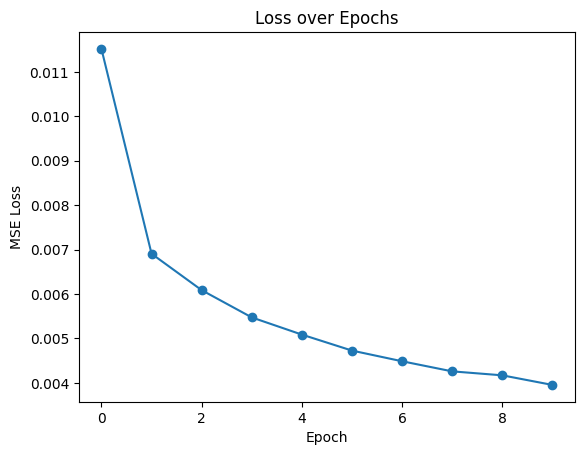

In [7]:
# Training loop
losses = []
for epoch in range(10):
    total_loss = 0
    for damaged, original in dataloader:
        damaged, original = damaged.to(device), original.to(device)
        output = model(damaged)
        loss = criterion(output, original)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}")
    losses.append(avg_loss)


torch.save(model.state_dict(), "realistic_art_restoration.pth")

# Plot loss
plt.plot(losses, marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

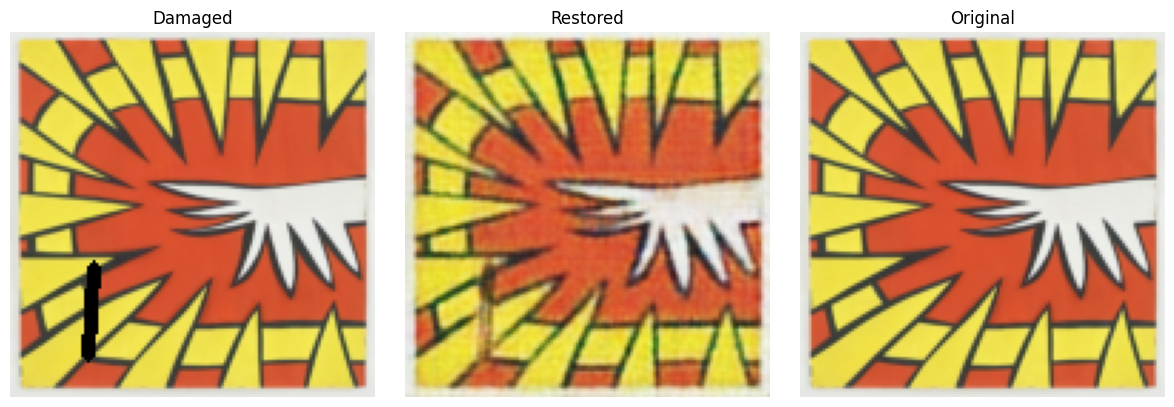

In [8]:

def show_side_by_side(damaged, restored, original):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(damaged.permute(1, 2, 0))
    axes[0].set_title("Damaged")
    axes[0].axis("off")

    axes[1].imshow(restored.permute(1, 2, 0))
    axes[1].set_title("Restored")
    axes[1].axis("off")

    axes[2].imshow(original.permute(1, 2, 0))
    axes[2].set_title("Original")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Test 
model.eval()
test_damaged, test_original = dataset[0]
with torch.no_grad():
    test_damaged_batch = test_damaged.unsqueeze(0).to(device)  # Add batch dimension
    restored_output = model(test_damaged_batch)
    restored_image = restored_output.squeeze(0).cpu()


show_side_by_side(test_damaged, restored_image, test_original)
